In [1]:
# load timecorr
import timecorr as tc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.spatial.distance import cdist
%matplotlib inline


In [2]:
width = 10

# define functions
laplace = {'name': 'Laplace', 'weights': tc.laplace_weights, 'params': {'scale': width}}
delta = {'name': '$\delta$', 'weights': tc.eye_weights, 'params': tc.eye_params}
gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}
mexican_hat = {'name': 'Mexican hat', 'weights': tc.mexican_hat_weights, 'params': {'sigma': width}}

In [3]:
def create_cov(cov, K):

    if cov is 'eye':
        R = np.eye(K)
    elif cov is 'toeplitz':
        R = scipy.linalg.toeplitz(np.linspace(0, 1, K)[::-1])
    elif cov is 'random':
        R = datasets.make_spd_matrix(K, random_state=1)
        R -= np.min(R)
        R /= np.max(R)
    elif isinstance(cov, np.ndarray):
        R = cov
    return R

In [4]:
def toeplitz_dataset(K, T, *args):

    corrs = np.zeros([T, int((K ** 2 - K) / 2 + K)])
    Y = np.zeros([T, K])

    for t in np.arange(T):
        corrs[t, :] = tc.mat2vec(create_cov('toeplitz', K))
        Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=tc.vec2mat(corrs[t, :]))

    return Y, corrs


In [5]:
def recovery_corrs(truth, guess):

    return np.diag(1 - cdist(truth[:, K:], guess[:, K:], 'correlation'))

In [6]:
def kron_time(mat_corr1, mat_corr2, T, K, kroned=True):
    """
    two KxKxT matrices
    """
    Y = np.zeros([T, K])
    truth_k = np.zeros([T, int((K ** 2 - K) / 2 + K)])
    
    for t in np.arange(T):

        if kroned:
            k = np.kron(mat_corr1[:, :, t], mat_corr2[:, :, t])
            #k = np.abs(k)
            
        else:
            k = np.dot(np.atleast_2d(mat_corr1[:, :, t].ravel()).T, np.atleast_2d(mat_corr1[:, :, t].ravel()))
            
        k2 = np.random.multivariate_normal(mean=np.zeros([k.shape[0]]), cov=k).reshape((K, K))
        
        k2 = np.abs(k2)
        
        ks = (k2 + k2.T)
        ks /= np.max(np.abs(ks))
        np.fill_diagonal(ks, 1.)

        truth_k[t, :] = tc.mat2vec(ks)
        Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=tc.vec2mat(truth_k[t, :]))

    return Y, truth_k

In [7]:
T = 30
K = 4


In [8]:
data1, toe_corr1 = toeplitz_dataset(K, T)
data2, toe_corr2 = toeplitz_dataset(K, T)
data3, toe_corr3 = toeplitz_dataset(K, T)
data4, toe_corr4 = toeplitz_dataset(K, T)

In [9]:
mat_toe_corr_1 = tc.vec2mat(toe_corr1)
mat_toe_corr_2 = tc.vec2mat(toe_corr2)
mat_toe_corr_3 = tc.vec2mat(toe_corr3)
mat_toe_corr_4 = tc.vec2mat(toe_corr4)

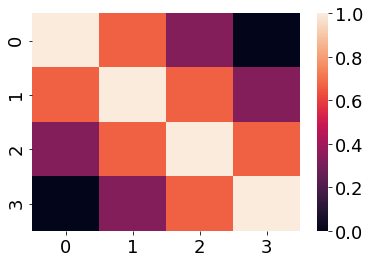

In [10]:
sns.heatmap(mat_toe_corr_1[:, :, 20])

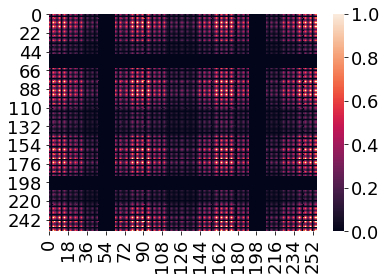

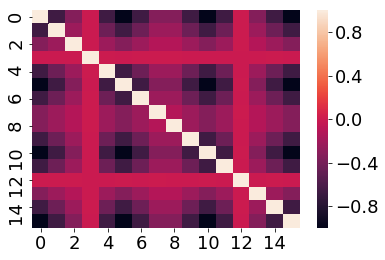

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: RuntimeWarning: covariance is not positive-semidefinite.


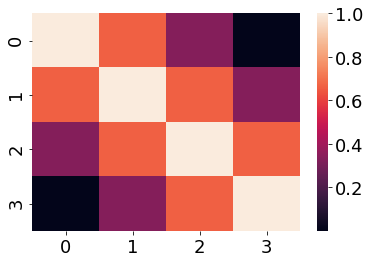

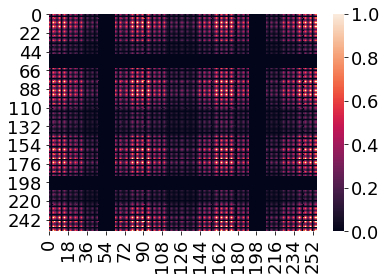

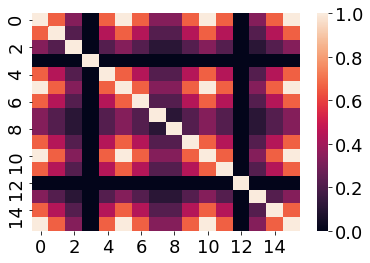

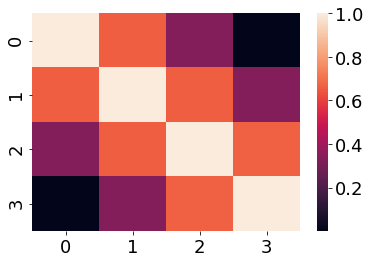

<Figure size 432x288 with 0 Axes>

In [11]:
for t in [10, 20]:
    
    k_1 = np.dot(np.atleast_2d(mat_toe_corr_1[:, :, t].ravel()).T, np.atleast_2d(mat_toe_corr_2[:, :, t].ravel()))
    k_2 = np.dot(np.atleast_2d(mat_toe_corr_3[:, :, t].ravel()).T, np.atleast_2d(mat_toe_corr_4[:, :, t].ravel()))
    
    k = np.dot(np.atleast_2d(k_1.ravel()).T, np.atleast_2d(k_2.ravel()))
    sns.heatmap(k)
    plt.show()
    plt.clf()
    k_mat_1 = np.random.multivariate_normal(mean=np.zeros([k.shape[0]]), cov=k).reshape((K*K, K*K))
    
    k_t = np.abs(k_mat_1)
    k_t = k_mat_1
#     np.ceil(k_mat_1, 0)
    #k_t = k_mat_1.clip(min=0)
    k_mat = (k_t + k_t.T)
    k_mat /= np.max(np.abs(k_mat))
    np.fill_diagonal(k_mat, 1.)
    sns.heatmap(k_mat)
    plt.show()
    plt.clf()
    
    k_mat_2 = np.random.multivariate_normal(mean=np.zeros([k_mat_1.shape[0]]), cov=k_mat_1).reshape((K, K))
    k_t = k_mat_2
    k_t = np.abs(k_mat_2)
    #np.ceil(k_mat_2, 0)
    #k_t = k_mat_2.clip(min=0)
    k_mat = (k_t + k_t.T)
    k_mat /= np.max(np.abs(k_mat))
    np.fill_diagonal(k_mat, 1.)
    sns.heatmap(k_mat)
    plt.show()
    plt.clf()

In [12]:
#Y, truth_k = kron_time(mat_toe_corr_1, mat_toe_corr_2, T=T, K=K, kroned=True) ## this is crazy low
Y, truth_k = kron_time(mat_toe_corr_1, mat_toe_corr_2, T=T, K=K, kroned=False)

In [13]:
truth_k_mat = tc.vec2mat(truth_k)


In [14]:
second_order_vec = tc.timecorr(Y, weights_function=tc.gaussian_weights, weights_params={'var': 10})

In [15]:
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(truth_k[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))
corr_corr2.mean()

0.9847873559196461

In [16]:
second_order = tc.vec2mat(second_order_vec)

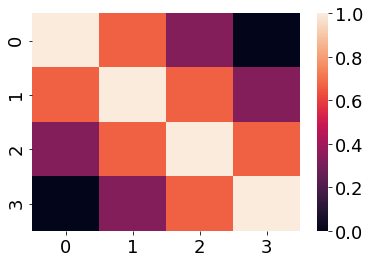

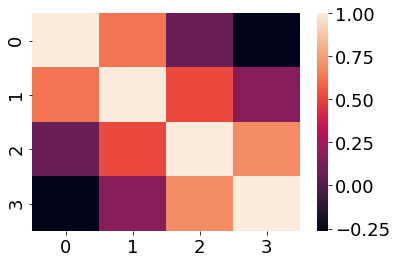

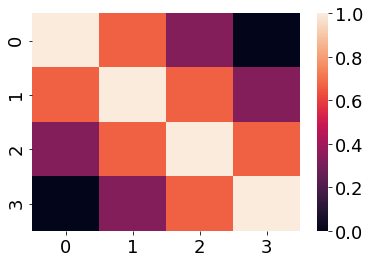

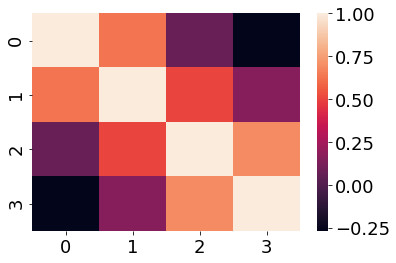

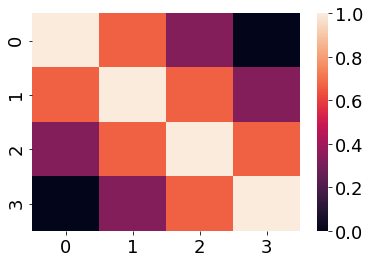

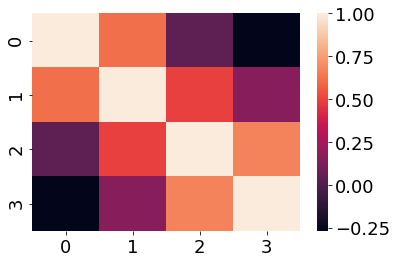

<Figure size 432x288 with 0 Axes>

In [17]:
for i in [2, 4, 10]:
    sns.heatmap(truth_k_mat[:, :, i])
    plt.show()
    plt.gcf()
    sns.heatmap(second_order[:, :, i])
    plt.show()
    plt.gcf()

In [18]:
k = np.kron(mat_toe_corr_1[:, :, 3], mat_toe_corr_2[:, :, 3])

k2 = np.random.multivariate_normal(mean=np.zeros([k.shape[0]]), cov=k).reshape((K, K))

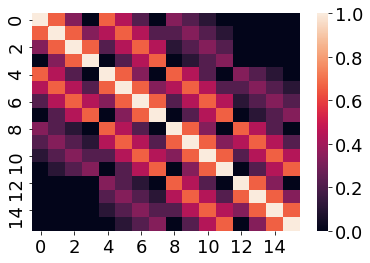

In [19]:
sns.heatmap(k)

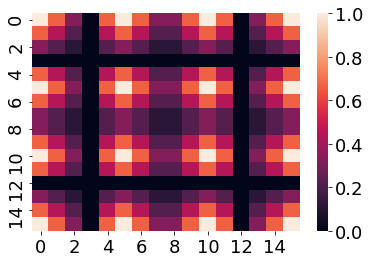

In [20]:
sns.heatmap(np.dot(np.atleast_2d(mat_toe_corr_1[:, :, 3].ravel()).T, np.atleast_2d(mat_toe_corr_2[:, :, 3].ravel())))

In [21]:
k = np.dot(np.atleast_2d(mat_toe_corr_1[:, :, 4].ravel()).T, np.atleast_2d(mat_toe_corr_2[:, :, 4].ravel()))

In [22]:
k2 = np.random.multivariate_normal(mean=np.zeros([k.shape[0]]), cov=k).reshape((K, K))

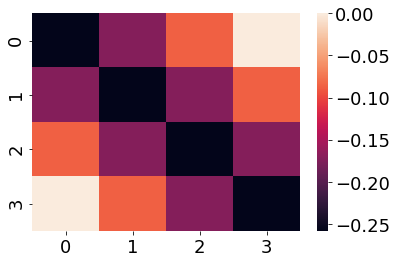

In [23]:
sns.heatmap(k2)

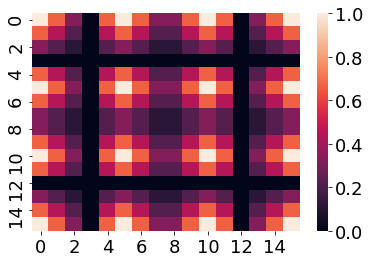

In [24]:
sns.heatmap(k)

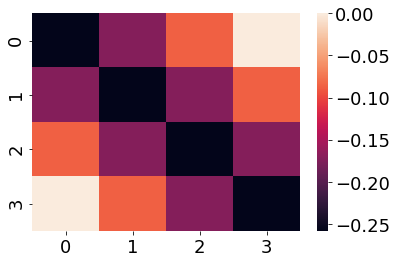

In [25]:
sns.heatmap(k2)

In [26]:
data1, corr1 = tc.simulate_data(datagen='ramping', return_corrs=True, set_random_seed=6, S=1, T=T, K=K)

data2, corr2  = tc.simulate_data(datagen='ramping', return_corrs=True, set_random_seed=5, S=1, T=T, K=K)

In [27]:

# convert from vector to matrix format
mat_corr_1 = tc.vec2mat(corr1)
mat_corr_2 = tc.vec2mat(corr2)

In [28]:
Y, truth_k = kron_time(mat_corr_1, mat_corr_2, T=T, K=K, kroned=False)

In [29]:
truth_k.shape

(30, 10)

In [30]:
second_order_vec = tc.timecorr(Y, weights_function=tc.gaussian_weights, weights_params={'var': 10})

In [31]:
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(truth_k[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))


In [32]:
corr_corr2.mean()

0.7404787288225758

In [33]:
second_order_vec.shape

(30, 10)

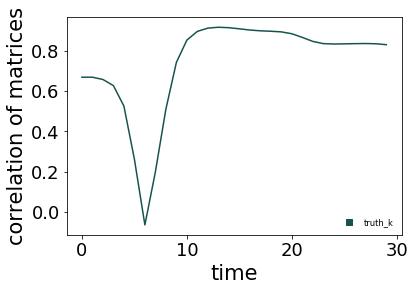

In [34]:
conditions = ['truth_k']
colors = sns.color_palette("cubehelix", 3)

for e, c in enumerate(conditions):

    plt.plot(np.diag(1 - cdist(np.atleast_2d(eval(c)[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))
, color = colors[e])
    plt.xlabel('time')
    plt.ylabel('correlation of matrices')

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
legend = plt.legend([f("s", colors[i]) for i in range(3)], conditions, loc=4, framealpha=1, frameon=False, fontsize = 'small')
plt.show()

In [35]:
second_order_vec = tc.timecorr(Y, weights_function=tc.eye_weights)

In [36]:
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(truth_k[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))


In [37]:
corr_corr2.mean()

0.5090738357830303

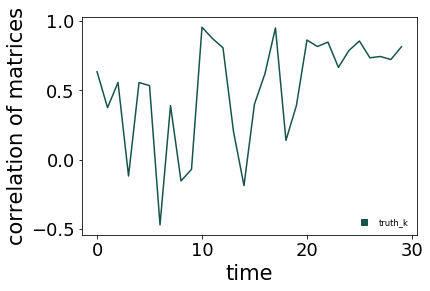

In [38]:
conditions = ['truth_k']
colors = sns.color_palette("cubehelix", 3)

for e, c in enumerate(conditions):

    plt.plot(np.diag(1 - cdist(np.atleast_2d(eval(c)[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))
, color = colors[e])
    plt.xlabel('time')
    plt.ylabel('correlation of matrices')

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
legend = plt.legend([f("s", colors[i]) for i in range(3)], conditions, loc=4, framealpha=1, frameon=False, fontsize = 'small')
plt.show()

In [39]:
data1, corr1 = tc.simulate_data(datagen='random', return_corrs=True, set_random_seed=10, S=1, T=T, K=K)

data2, corr2  = tc.simulate_data(datagen='random', return_corrs=True, set_random_seed=7, S=1, T=T, K=K)

# convert from vector to matrix format
mat_corr_1 = tc.vec2mat(corr1)
mat_corr_2 = tc.vec2mat(corr2)

Y, truth_k = kron_time(mat_corr_1, mat_corr_2, T=T, K=K, kroned=False)
second_order_vec = tc.timecorr(Y, weights_function=delta['weights'], weights_params={'var': 10})
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(truth_k[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))


In [40]:
corr_corr2.mean()

0.46487564902951956

In [41]:
mat_toe_corr_1 = tc.vec2mat(toe_corr1)
mat_toe_corr_2 = tc.vec2mat(toe_corr2)
mat_toe_corr_3 = tc.vec2mat(toe_corr3)
mat_toe_corr_4 = tc.vec2mat(toe_corr4)


Y = np.zeros([T, K])
truth_k = np.zeros([T, int((K ** 2 - K) / 2 + K)])

for t in np.arange(T):


    k = np.dot(np.atleast_2d(mat_toe_corr_1[:, :, t].ravel()).T, np.atleast_2d(mat_toe_corr_2[:, :, t].ravel()))

    k2 = np.random.multivariate_normal(mean=np.zeros([k.shape[0]]), cov=k).reshape((K, K))

    k2 = np.abs(k2)

    ks = (k2 + k2.T)
    ks /= np.max(np.abs(ks))
    np.fill_diagonal(ks, 1.)

    truth_k[t, :] = tc.mat2vec(ks)
    Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=tc.vec2mat(truth_k[t, :]))

In [42]:
second_order_vec = tc.timecorr(Y, weights_function=delta['weights'], weights_params={'var': 10})
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(truth_k[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))


In [43]:
corr_corr2

array([ 0.86161535,  0.8140937 ,  0.68782554,  0.86924972,  0.74931908,
        0.88046231,  0.91411115,  0.82685034,  0.77863686,  0.56035177,
        0.90368829,  0.35580285,  0.79194452,  0.68397114,  0.53708673,
       -0.00550577,  0.86131885,  0.14062958,  0.83778966,  0.18441519,
        0.80403015,  0.9102954 ,  0.90067928,  0.99899468,  0.84680268,
        0.08403694,  0.86180456,  0.73236754,  0.95560837,  0.76814883])

In [44]:
t = 5

In [45]:
k_1 = np.dot(np.atleast_2d(mat_toe_corr_1[:, :, t].ravel()).T, np.atleast_2d(mat_toe_corr_2[:, :, t].ravel()))
k_2 = np.dot(np.atleast_2d(mat_toe_corr_3[:, :, t].ravel()).T, np.atleast_2d(mat_toe_corr_4[:, :, t].ravel()))

k = np.dot(np.atleast_2d(k_1.ravel()).T, np.atleast_2d(k_2.ravel()))

In [46]:
# k_1 = np.dot(np.atleast_2d(mat_toe_corr_1.ravel()).T, np.atleast_2d(mat_toe_corr_2.ravel()))
# k_2 = np.dot(np.atleast_2d(mat_toe_corr_3.ravel()).T, np.atleast_2d(mat_toe_corr_4.ravel()))

# k = np.dot(np.atleast_2d(k_1.ravel()).T, np.atleast_2d(k_2.ravel()))

In [47]:
k.shape

(256, 256)

In [531]:
corrs = [toeplitz_dataset(T, K) for i in range(4)]


In [532]:
Y = np.zeros([T, K])
truth_k = np.zeros([T, int((K ** 2 - K) / 2 + K)])

for t in np.arange(T):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-532-76f15c180423>, line 5)

In [265]:
k = toe_corr1
mat_k = tc.vec2mat(k)
x = np.copy(mat_k)

In [266]:
def corrs_dot(k, t):
    k_t= np.dot(np.atleast_2d(k[:, :, t].ravel()).T, np.atleast_2d(k[:, :, t].ravel()))
    #k_mat = se.helpers._z2r((se.helpers._r2z(k_t) * se.helpers._r2z(k_t).T)/2)
#     k_mat = (k_t + k_t.T)
#     k_mat /= np.max(np.abs(k_mat))
    return k_mat

In [254]:
def gen_corrs(k, order=1):
    x = np.copy(k)
    T = x.shape[2]
    xs = []
#     if order ==1:
#         return x
#     else:
    xs.append(x)
    for n in np.arange(order-1):
        new_K = x.shape[1]**2
        new_x = np.zeros([new_K, new_K, T])
        #next_order = np.zeros([T, int((new_K ** 2 - new_K) / 2 + new_K)])
        for t in np.arange(T):
            new_x[:, :, t] = corrs_dot(x, t)
#             sns.heatmap(corrs_dot(x, t))
#             plt.show()
#             plt.clf()
        x = new_x
        xs.append(new_x)
    return xs

In [255]:
def rand_draw(k, order=1):
    x = np.copy(k[order-1])
    T = x.shape[2]
    x_1 = np.copy(k[order-2])
    truth_k = list()
    for n in np.arange(order)[order:0:-1]:
        K = int(x.shape[1]**(1/(2**n)))
        new_K = K ** (n)
        new_x = np.zeros([new_K, new_K, T])
        Y = np.zeros([T, new_K])
        for t in np.arange(T):
            x_slice = x[:, :, t]
            x_1_slice = x_1[:, :, t]
            ## take the template 
            k_mat = np.random.multivariate_normal(mean=x_1_slice.ravel(), cov=x_slice).reshape((new_K, new_K))
            k_mat = (se.helpers._r2z(k_mat) * se.helpers._r2z(k_mat).T)/2
            #k_t = np.dot(np.atleast_2d(k_mat_1.ravel()).T, np.atleast_2d(k_mat_1.ravel())
            ## do the fisher z transformation - then add z transpose then divide by 2
        #     k_t = np.abs(k_mat)
        #     k_mat = (k_t + k_t.T)
        #     k_mat /= np.max(np.abs(k_mat))
            np.fill_diagonal(k_mat, 1.)
            new_x[:, :, t] = k_mat
            #Y[t, :] = np.random.multivariate_normal(mean=np.zeros([new_K]), cov=k_mat)
            if n == 1:
                Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=k_mat)

        x = new_x
        truth_k.append(x)
        #Y_list.append(Y)
        
        
    return truth_k, Y
    

In [256]:
# def rand_draw(k, order=1):
#     x = np.copy(k)
#     T = x.shape[2]
#     truth_k = list()
#     for n in np.arange(order)[order:0:-1]:
#         K = int(x.shape[1]**(1/(2*n)))
#         new_K = K ** (n)
#         new_x = np.zeros([new_K, new_K, T])
#         Y = np.zeros([T, new_K])
#         for t in np.arange(T):
#             x_slice = x[:, :, t]
#             k_t = np.random.multivariate_normal(mean=np.zeros([x_slice.shape[0]]), cov=x_slice).reshape((new_K, new_K))
#             #k_t = np.dot(np.atleast_2d(k_mat_1.ravel()).T, np.atleast_2d(k_mat_1.ravel())
#             k_t = np.abs(k_)
#             k_mat = (k_t + k_t.T)
#             k_mat /= np.max(np.abs(k_mat))
#             np.fill_diagonal(k_mat, 1.)
#             new_x[:, :, t] = k_mat
#             #Y[t, :] = np.random.multivariate_normal(mean=np.zeros([new_K]), cov=k_mat)
#             if n == 1:
#                 Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=k_mat)
            
#         x = new_x
#         truth_k.append(x)
#         #Y_list.append(Y)
        
        
#     return truth_k, Y
    

In [257]:
# def rand_draw(k, order=1):
#     x = np.copy(k)
#     T = x.shape[2]
#     truth_k = list()
#     for n in np.arange(order)[order:0:-1]:
#         K = int(x.shape[1]**(1/(2**n)))
#         new_K = K ** (n)
#         new_x = np.zeros([new_K, new_K, T])
#         Y = np.zeros([T, new_K])
#         for t in np.arange(T):
#             x_slice = x[:, :, t]
#             k_draw = np.random.multivariate_normal(mean=np.zeros([x_slice.shape[0]]), cov=x_slice).reshape((new_K, new_K))
#             k_mat_1 = np.dot(np.atleast_2d(k_draw.ravel()).T, np.atleast_2d(k_draw.ravel()))
#             k_t = np.abs(k_mat_1)
#             k_mat = (k_t + k_t.T)
#             k_mat /= np.max(np.abs(k_mat))
#             np.fill_diagonal(k_mat, 1.)

#             k_mat_2 = np.random.multivariate_normal(mean=np.zeros([k_mat_1.shape[0]]), cov=k_mat_1).reshape((new_K, new_K))

#             new_x[:, :, t] = k_mat_2
#             #Y[t, :] = np.random.multivariate_normal(mean=np.zeros([new_K]), cov=k_mat)
#             if n == 1:
#                 Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=k_mat_2)
            
#         x = new_x
#         truth_k.append(x)
#         #Y_list.append(Y)
        
        
#     return truth_k, Y
    

In [258]:
try_ord = gen_corrs(x, order=3)

In [259]:
x.shape

(4, 4, 30)

In [260]:
try_ord[0].shape

(4, 4, 30)

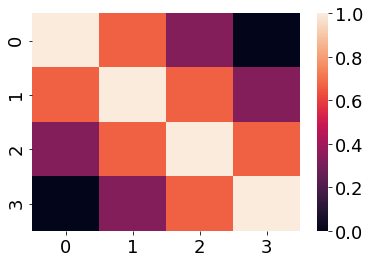

In [261]:
sns.heatmap(try_ord[0][:, :, 10])

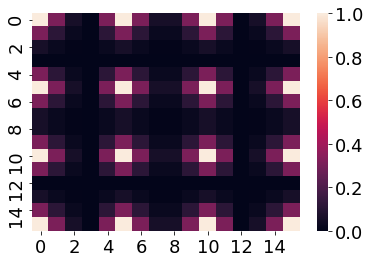

In [262]:
sns.heatmap(try_ord[1][:, :, 10])

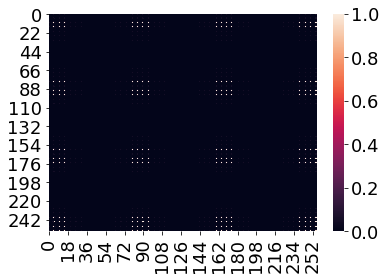

In [263]:
sns.heatmap(try_ord[2][:, :, 10])

In [214]:
x_1_slice.shape

(4, 4)

In [215]:
x_slice.shape

(16, 16)

In [216]:
x = np.copy(k[order-1])

In [217]:
x.shape

(256, 256, 30)

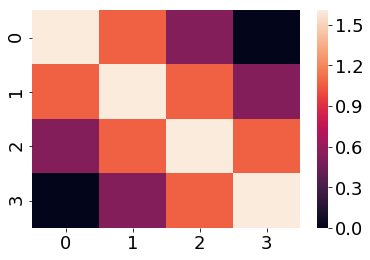

In [218]:
sns.heatmap(x_1_slice)

In [219]:
np.random.multivariate_normal(mean=x_1_slice.ravel(), cov=x_slice).reshape((new_K, new_K))

array([[ 1.26645809e+00,  8.45407610e-01,  4.21781388e-01,
        -7.06328221e-05],
       [ 8.43724393e-01,  1.26641995e+00,  8.43057025e-01,
         4.23436121e-01],
       [ 4.22820261e-01,  8.43338932e-01,  1.26638407e+00,
         8.43070587e-01],
       [ 3.47019966e-04,  4.23609141e-01,  8.44303182e-01,
         1.26600865e+00]])

In [220]:
import matplotlib.pyplot as plt

In [221]:
k = try_ord
order = 3
x = np.copy(k[order-1])
T = x.shape[2]
truth_k = list()
for n in np.arange(order)[order:0:-1]:
    print(n)
    print(n-1)
    x_1 = np.copy(k[n-1])
    print(x_1.shape)
    K = int(x.shape[1]**(1/(2**n)))
    new_K = K ** (n)
    new_x = np.zeros([new_K, new_K, T])
    Y = np.zeros([T, new_K])
    for t in np.arange(T):
        x_slice = x[:, :, t]
        x_1_slice = x_1[:, :, t]
        print(x_slice.shape)
        print(x_1_slice.shape)
        k_mat = np.random.multivariate_normal(mean=x_1_slice.ravel(), cov=x_slice).reshape((new_K, new_K))
#         k_mat = se.helpers._z2r(np.dot(se.helpers._r2z(k_mat),se.helpers._r2z(k_mat).T)/2)
#         sns.heatmap(k_mat)
#         plt.clf()
        #k_mat = (se.helpers._r2z(k_mat) * se.helpers._r2z(k_mat).T)/2
        #k_t = np.dot(np.atleast_2d(k_mat_1.ravel()).T, np.atleast_2d(k_mat_1.ravel())
        ## do the fisher z transformation - then add z transpose then divide by 2
    #     k_t = np.abs(k_mat)
    #     k_mat = (k_t + k_t.T)
    #     k_mat /= np.max(np.abs(k_mat))
        #np.fill_diagonal(k_mat, 1.)
        new_x[:, :, t] = k_mat
        #Y[t, :] = np.random.multivariate_normal(mean=np.zeros([new_K]), cov=k_mat)
        if n == 1:
            print(k_mat)
            Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=k_mat)
    print(x)
    x = new_x
    truth_k.append(x)
    #Y_list.append(Y)

2
1
(16, 16, 30)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
(256, 256)
(16, 16)
[[[0.99642201 1.         1.         ... 1.         0.98757194 0.99583985]
  [0.66573797 0.66505138 0.6656479  ... 0.66601643 0.65436102 0.66440394]
  [0.32631695 0.3331891  0.33344436 ... 0.33344904 0.33127911 0.33196837]
  ...
  [0.33329205 0.33373867 0.33181867 ... 0.33231684 0.32948918 0.33238666]
  [0.65844976 0.66449673 0.66517047 ... 0.6648499  0.66164748 0.66492134]
  [0.99

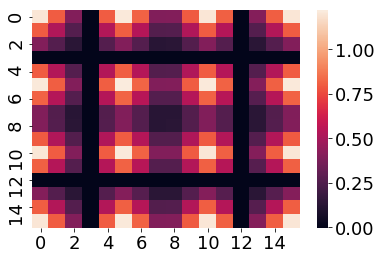

In [222]:
sns.heatmap(truth_k[0][:, :, 10])

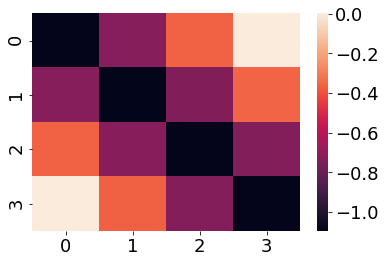

In [223]:
sns.heatmap(truth_k[1][:, :, 10])

In [182]:
try_x.shape

(256, 256, 30)

In [183]:
try_x = np.copy(try_ord[3-1])
try_T = try_x.shape[2]

In [141]:
k = try_ord
order=3
x = np.copy(k[order-1])
x_1 = np.copy(k[order-2])
T = x.shape[2]
truth_k = list()
for n in np.arange(order)[order:0:-1]:
    K = int(x.shape[1]**(1/(2**n)))
    new_K = K ** (n)
    new_x = np.zeros([new_K, new_K, T])
    Y = np.zeros([T, new_K])
    for t in np.arange(T):
        x_slice = x[:, :, t]
        x_1_slice = x_1[:, :, t]
        ## take the template 
        k_mat = np.random.multivariate_normal(mean=np.zeros([x_1_slice.shape[0]]), cov=x_slice).reshape((new_K, new_K))
        #k_t = np.dot(np.atleast_2d(k_mat_1.ravel()).T, np.atleast_2d(k_mat_1.ravel())
        ## do the fisher z transformation - then add z transpose then divide by 2
        k_t = np.abs(k_mat)
        k_mat = (k_t + k_t.T)
        k_mat /= np.max(np.abs(k_mat))
        np.fill_diagonal(k_mat, 1.)
        new_x[:, :, t] = k_mat
        #Y[t, :] = np.random.multivariate_normal(mean=np.zeros([new_K]), cov=k_mat)
        if n == 1:
            Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=k_mat)

ValueError: mean and cov must have same length

In [248]:
x_1[:, :, t].ravel().shape

(256,)

In [247]:
x[:, :, t].shape

(256, 256)

In [139]:
k = try_ord
order=3
x = np.copy(k[order-1])
x_1 = np.copy(k[order-2])
T = x.shape[2]
truth_k = list()
n = 2
K = int(x.shape[1]**(1/(2**n)))
new_K = K ** (n)
new_x = np.zeros([new_K, new_K, T])
Y = np.zeros([T, new_K])
for t in np.arange(T):
    x_slice = x[:, :, t]
    x_1_slice = x_1[:, :, t]
    ## take the template 
    k_mat = np.random.multivariate_normal(mean=x_1_slice[:, :, t].ravel(), cov=x_slice).reshape((new_K, new_K))
    k_mat = (se.helpers._r2z(k_mat) * se.helpers._r2z(k_mat).T)/2
    #k_t = np.dot(np.atleast_2d(k_mat_1.ravel()).T, np.atleast_2d(k_mat_1.ravel())
    ## do the fisher z transformation - then add z transpose then divide by 2
#     k_t = np.abs(k_mat)
#     k_mat = (k_t + k_t.T)
#     k_mat /= np.max(np.abs(k_mat))
    np.fill_diagonal(k_mat, 1.)
    new_x[:, :, t] = k_mat
    #Y[t, :] = np.random.multivariate_normal(mean=np.zeros([new_K]), cov=k_mat)
    if n == 1:
        Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=k_mat)

IndexError: too many indices for array

In [63]:
import supereeg as se

In [256]:
se.helpers._r2z(k_mat) * se.helpers._r2z(k_mat).T

array([[           inf, 6.47572363e-01, 1.20113217e-01, 3.26131133e-14,
        6.47572604e-01, 7.22191857e+01, 6.47572607e-01, 1.20113270e-01,
        1.20113229e-01, 6.47572543e-01, 7.33697765e+01, 6.47572749e-01,
        5.17807942e-15, 1.20113375e-01, 6.47572210e-01, 7.26260171e+01],
       [6.47572363e-01,            inf, 5.10726152e-02, 9.40275174e-17,
        2.28250461e-01, 6.47572645e-01, 2.28250443e-01, 5.10726388e-02,
        5.10725864e-02, 2.28250606e-01, 6.47572585e-01, 2.28250532e-01,
        4.23231928e-16, 5.10726271e-02, 2.28250554e-01, 6.47572529e-01],
       [1.20113217e-01, 5.10726152e-02,            inf, 2.17143605e-15,
        5.10726464e-02, 1.20113249e-01, 5.10726424e-02, 1.24482696e-02,
        1.24482574e-02, 5.10726354e-02, 1.20113232e-01, 5.10726149e-02,
        6.04008210e-15, 1.24482717e-02, 5.10726407e-02, 1.20113293e-01],
       [3.26131133e-14, 9.40275174e-17, 2.17143605e-15,            inf,
        8.29344813e-17, 7.54681102e-16, 1.30057466e-15, 2.945

In [67]:
truth_k, Y = rand_draw(try_ord, order=3)

ValueError: mean and cov must have same length

In [234]:
truth_k

[array([[[1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [0.66667215, 0.6666664 , 0.6666665 , ..., 0.66661419,
          0.66666641, 0.66666692],
         [0.3333247 , 0.33333342, 0.33333318, ..., 0.33326961,
          0.33333334, 0.3333331 ],
         ...,
         [0.33332678, 0.33333336, 0.33333332, ..., 0.33324685,
          0.33333315, 0.33333321],
         [0.66666116, 0.66666661, 0.66666659, ..., 0.66663989,
          0.66666672, 0.66666693],
         [0.99999225, 0.99999999, 0.99999995, ..., 1.        ,
          0.99999981, 1.        ]],
 
        [[0.66667215, 0.6666664 , 0.6666665 , ..., 0.66661419,
          0.66666641, 0.66666692],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [0.22221953, 0.22222227, 0.22222207, ..., 0.22221027,
          0.22222231, 0.22222218],
         ...,
         [0.22221736, 0.22222231, 0.22222216, ..., 0.2221955 ,
          0.22222222, 0.

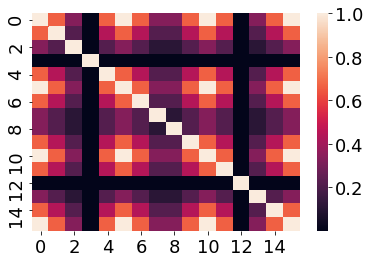

In [155]:
sns.heatmap(truth_k[0][:, :, 10])

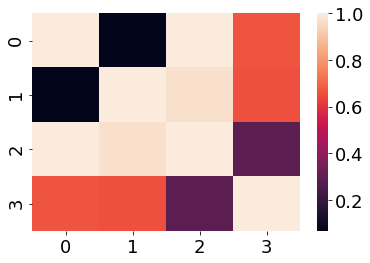

In [562]:
sns.heatmap(truth_k[1][:, :, 10])

In [184]:
second_order_vec = tc.timecorr(Y, weights_function=delta['weights'], weights_params={'var': 10})

In [185]:
second_order_vec.shape

(30, 10)

In [186]:
truth_k[1].shape

(4, 4, 30)

In [187]:
second_order_vec = tc.timecorr(Y, weights_function=delta['weights'], weights_params={'var': 10})
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(tc.mat2vec(truth_k[1])), np.atleast_2d(second_order_vec), 'correlation'))


In [188]:
corr_corr2.mean()

0.5655997795278965

In [189]:
Y.shape

(30, 4)

In [190]:
second_order_vec = tc.timecorr(Y, weights_function=delta['weights'], weights_params={'var': 10})
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(tc.mat2vec(truth_k[1])[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))


In [191]:
corr_corr2.mean()

0.5293437243792415

In [192]:
second_order_vec.shape

(30, 10)

In [193]:
second_order_mat = tc.vec2mat(second_order_vec)

In [194]:
tc.vec2mat(second_order_vec).shape

(4, 4, 30)

In [195]:
ravel_second = np.array([])
for t in np.arange(second_order_mat.shape[2]):
    print(t)
    if t==0:
        ravel_second = np.atleast_2d(second_order_mat[:, :, t].ravel())
    else:
        
        ravel_second = np.vstack((ravel_second, np.atleast_2d(second_order_mat[:, :, t].ravel())))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [196]:
ravel_second.shape

(30, 16)

In [197]:
third_order_vec = tc.timecorr(ravel_second, weights_function=delta['weights'], weights_params={'var': 10})

In [198]:
third_order_vec.shape

(30, 136)

In [199]:
tc.vec2mat(third_order_vec).shape

(16, 16, 30)

In [200]:
tc.vec2mat(third_order_vec).shape

(16, 16, 30)

In [201]:
tc.mat2vec(truth_k[0]).shape

(30, 136)

In [202]:
truth_k[0].shape

(16, 16, 30)

In [203]:
second_order_vec = tc.timecorr(Y, weights_function=delta['weights'], weights_params={'var': 10})
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(tc.mat2vec(truth_k[1])[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))

third_order_vec = tc.timecorr(ravel_second, weights_function=delta['weights'], weights_params={'var': 10})
corr_corr3 = np.diag(1 - cdist(np.atleast_2d(tc.mat2vec(truth_k[0])[:, K:]), np.atleast_2d(third_order_vec[:, K:]), 'correlation'))


In [204]:
corr_corr3.mean()

-0.0904644547459097

In [102]:
# def recursive_corrs(k, order=1):
#     if order == 1:
#         return k
#     else:
#         k_past = recursive_corrs(k, order-1)
#         return np.dot(np.atleast_2d(k_past.ravel()).T, np.atleast_2d(k_past.ravel()))
#recursive_corrs(k1, order=3)this works 
#recursive_corrs(k1, order=4)this blows up